In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



In [2]:
df = pd.read_csv('spambase_v6.csv')

In [3]:
df.head()

,Unnamed: 0,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,is_spam
0,0,0.00,0.64,0.64,0.0,0.32,0.00,0,0,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,True
1,1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,True
2,2,0.06,0,0.71,0.0,1.23,0.19,0.19,0.12,0.64,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,True
3,3,0.00,0,0.00,0.0,0.63,0.00,0.31,0.63,0.31,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,True
4,4,0.00,0,0.00,0.0,0.63,0.00,0.31,0.63,0.31,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,True


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 59 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  4601 non-null   int64  
 1   word_freq_make              4601 non-null   float64
 2   word_freq_address           4601 non-null   object 
 3   word_freq_all               4595 non-null   float64
 4   word_freq_3d                4599 non-null   float64
 5   word_freq_our               4601 non-null   object 
 6   word_freq_over              4600 non-null   float64
 7   word_freq_remove            4601 non-null   object 
 8   word_freq_internet          4586 non-null   object 
 9   word_freq_order             4601 non-null   float64
 10  word_freq_mail              4601 non-null   float64
 11  word_freq_receive           4601 non-null   float64
 12  word_freq_will              4601 non-null   float64
 13  word_freq_people            4601 

In [5]:
# Extracted columns with object data type to inspect them
columns_to_change = df.select_dtypes(exclude=['float64','int64','bool'])
columns_to_change

,word_freq_address,word_freq_our,word_freq_remove,word_freq_internet,word_freq_report,word_freq_addresses,word_freq_000,word_freq_hpl,word_freq_labs
0,0.64,0.32,0,0,0,0,0,0,NaN
1,0.28,0.14,0.21,0.07,0.21,0.14,0.43,0,NaN
2,0,1.23,0.19,0.12,0,1.75,1.16,0,NaN
3,0,0.63,0.31,0.63,0,0,0,0,NaN
4,0,0.63,0.31,0.63,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...
4596,0,0,0,0,0,zero,0,0,0
4597,0,0,0,0,0,0,0,0,0
4598,0,0,0,0,0,0,0,0,0
4599,0,0.32,0,0,0,0,0,0,0


In [6]:
print(df['word_freq_our'].unique())


['0.32' '0.14' '1.23' '0.63' '1.85' '1.92' '1.88' '0.61' '0.19' '0' '0.38'
 '0.34' '0.9' '0.71' '1.27' '0.94' '1.11' '1.59' '0.76' '2.94' '1.16'
 '0.65' '1.89' '1.46' '0.48' '0.41' '0.52' '0.45' '1.57' '0.05' '0.42'
 '0.23' '1.39' '0.68' '1.32' '1.26' '0.53' '0.44' '0.46' '1.44' '0.18'
 '1.67' '1.28' '1.4' '1.15' '0.4' '2.24' '0.35' '0.43' '4.25' '0.95'
 '0.88' '0.51' '0.1' '2.23' '0.15' '0.92' '0.33' '1.51' '1.6' '0.56'
 '0.66' '1.49' '1.65' '0.29' '0.81' '2.25' '2.7' '0.62' '1.31' '1.36'
 '0.85' '0.27' '2.1' '0.3' '0.26' '0.5' '0.54' '0.89' '0.08' '0.87' '0.11'
 '6.25' '0.8' '2.19' '1.17' '0.55' '1.77' '2.5' '0.25' '0.96' '1.03'
 '0.39' '0.64' '0.69' '1.81' '1.09' '0.22' '0.31' '1.38' '0.99' '1.24'
 '2.33' '0.75' '1.14' '0.2' '0.78' '1.63' '1.29' '0.16' '0.58' '0.91'
 '0.17' '2' '0.36' '1.93' '1.3' '0.02' '7.69' '0.67' '1.22' '1.48' '0.7'
 '1.21' '1.78' '1.52' '0.59' '1.55' '1.05' '3.48' '0.84' '0.24' '0.28'
 '1.25' '0.09' '1.82' '0.6' '1.34' '1.79' '0.82' '1.02' '1.07' '0.13'
 '0.12

In [7]:
# changed the columns types to float, values like (zero, ???, None) will become null values
columns_to_change = columns_to_change.columns.tolist()
df[columns_to_change] = df[columns_to_change].apply(pd.to_numeric, errors='coerce')

In [8]:
# checking the number of null values within the dataframe
print(df.isna().sum())


Unnamed: 0                      0
word_freq_make                  0
word_freq_address               1
word_freq_all                   6
word_freq_3d                    2
word_freq_our                   1
word_freq_over                  1
word_freq_remove                1
word_freq_internet             16
word_freq_order                 0
word_freq_mail                  0
word_freq_receive               0
word_freq_will                  0
word_freq_people                0
word_freq_report                1
word_freq_addresses           321
word_freq_free                  0
word_freq_business              0
word_freq_email                 0
word_freq_you                   0
word_freq_credit                0
word_freq_your                  0
word_freq_font                  0
word_freq_000                   1
word_freq_money                 0
word_freq_hp                    0
word_freq_hpl                   1
word_freq_george                0
word_freq_650                   0
word_freq_lab 

In [9]:
# fill null values with 0's
df = df.fillna(0)
# dropped first column as it is not relevant
df = df.drop(columns='Unnamed: 0')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   word_freq_make              4601 non-null   float64
 1   word_freq_address           4601 non-null   float64
 2   word_freq_all               4601 non-null   float64
 3   word_freq_3d                4601 non-null   float64
 4   word_freq_our               4601 non-null   float64
 5   word_freq_over              4601 non-null   float64
 6   word_freq_remove            4601 non-null   float64
 7   word_freq_internet          4601 non-null   float64
 8   word_freq_order             4601 non-null   float64
 9   word_freq_mail              4601 non-null   float64
 10  word_freq_receive           4601 non-null   float64
 11  word_freq_will              4601 non-null   float64
 12  word_freq_people            4601 non-null   float64
 13  word_freq_report            4601 

In [11]:
df['is_spam'].value_counts()


is_spam
False    2788
True     1813
Name: count, dtype: int64

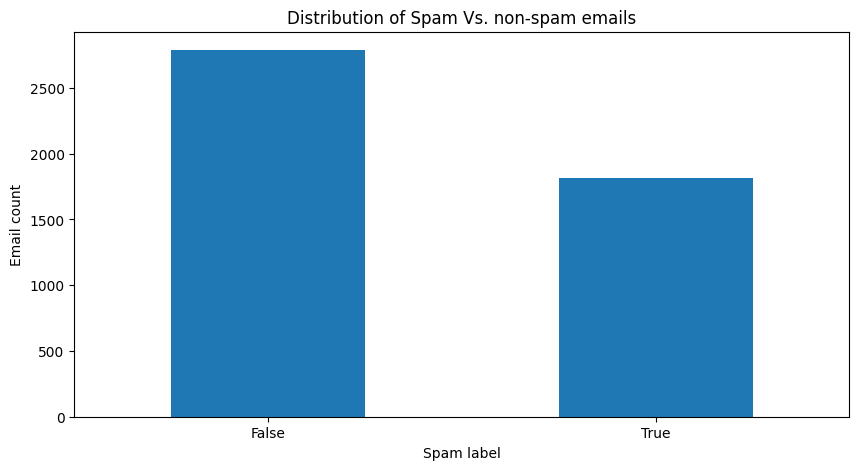

In [12]:
## Distrbution of spam and non spam emails
plt.figure(figsize=(10,5))
df['is_spam'].value_counts().plot(kind='bar')
plt.xlabel("Spam label")
plt.ylabel("Email count")
plt.title("Distribution of Spam Vs. non-spam emails")
plt.xticks(rotation=0)  
plt.show()

In [13]:
cormat = df.corr()
round(cormat,2)


,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,is_spam
word_freq_make,1.00,-0.02,0.07,0.01,0.02,0.06,0.01,-0.00,0.11,0.04,...,-0.03,-0.02,-0.03,0.06,0.12,-0.01,0.04,0.06,0.09,0.13
word_freq_address,-0.02,1.00,-0.03,-0.01,-0.02,-0.02,0.00,-0.02,-0.00,0.03,...,-0.01,-0.05,-0.02,-0.01,-0.01,0.00,0.00,0.00,-0.02,-0.03
word_freq_all,0.07,-0.03,1.00,-0.02,0.08,0.09,0.04,0.01,0.09,0.03,...,-0.03,-0.02,-0.03,0.11,0.09,-0.00,0.10,0.11,0.07,0.20
word_freq_3d,0.01,-0.01,-0.02,1.00,0.00,-0.01,0.02,0.01,-0.00,-0.00,...,-0.00,-0.01,-0.01,-0.00,0.01,-0.00,0.01,0.02,0.02,0.06
word_freq_our,0.02,-0.02,0.08,0.00,1.00,0.05,0.15,0.03,0.02,0.03,...,-0.03,-0.05,-0.03,0.03,0.04,0.00,0.05,0.05,0.00,0.24
word_freq_over,0.06,-0.02,0.09,-0.01,0.05,1.00,0.06,0.08,0.12,0.01,...,-0.02,-0.01,-0.02,0.07,0.11,0.02,-0.01,0.09,0.08,0.23
word_freq_remove,0.01,0.00,0.04,0.02,0.15,0.06,1.00,0.04,0.05,0.06,...,-0.03,-0.05,-0.03,0.05,0.07,0.05,0.04,0.06,-0.01,0.33
word_freq_internet,-0.00,-0.02,0.01,0.01,0.03,0.08,0.04,1.00,0.11,0.08,...,-0.03,-0.03,-0.02,0.03,0.06,-0.01,0.01,0.04,0.04,0.21
word_freq_order,0.11,-0.00,0.09,-0.00,0.02,0.12,0.05,0.11,1.00,0.13,...,-0.01,-0.03,0.01,0.04,0.15,-0.00,0.11,0.19,0.25,0.23
word_freq_mail,0.04,0.03,0.03,-0.00,0.03,0.01,0.06,0.08,0.13,1.00,...,0.01,0.00,0.01,0.04,0.08,0.04,0.07,0.10,0.09,0.14


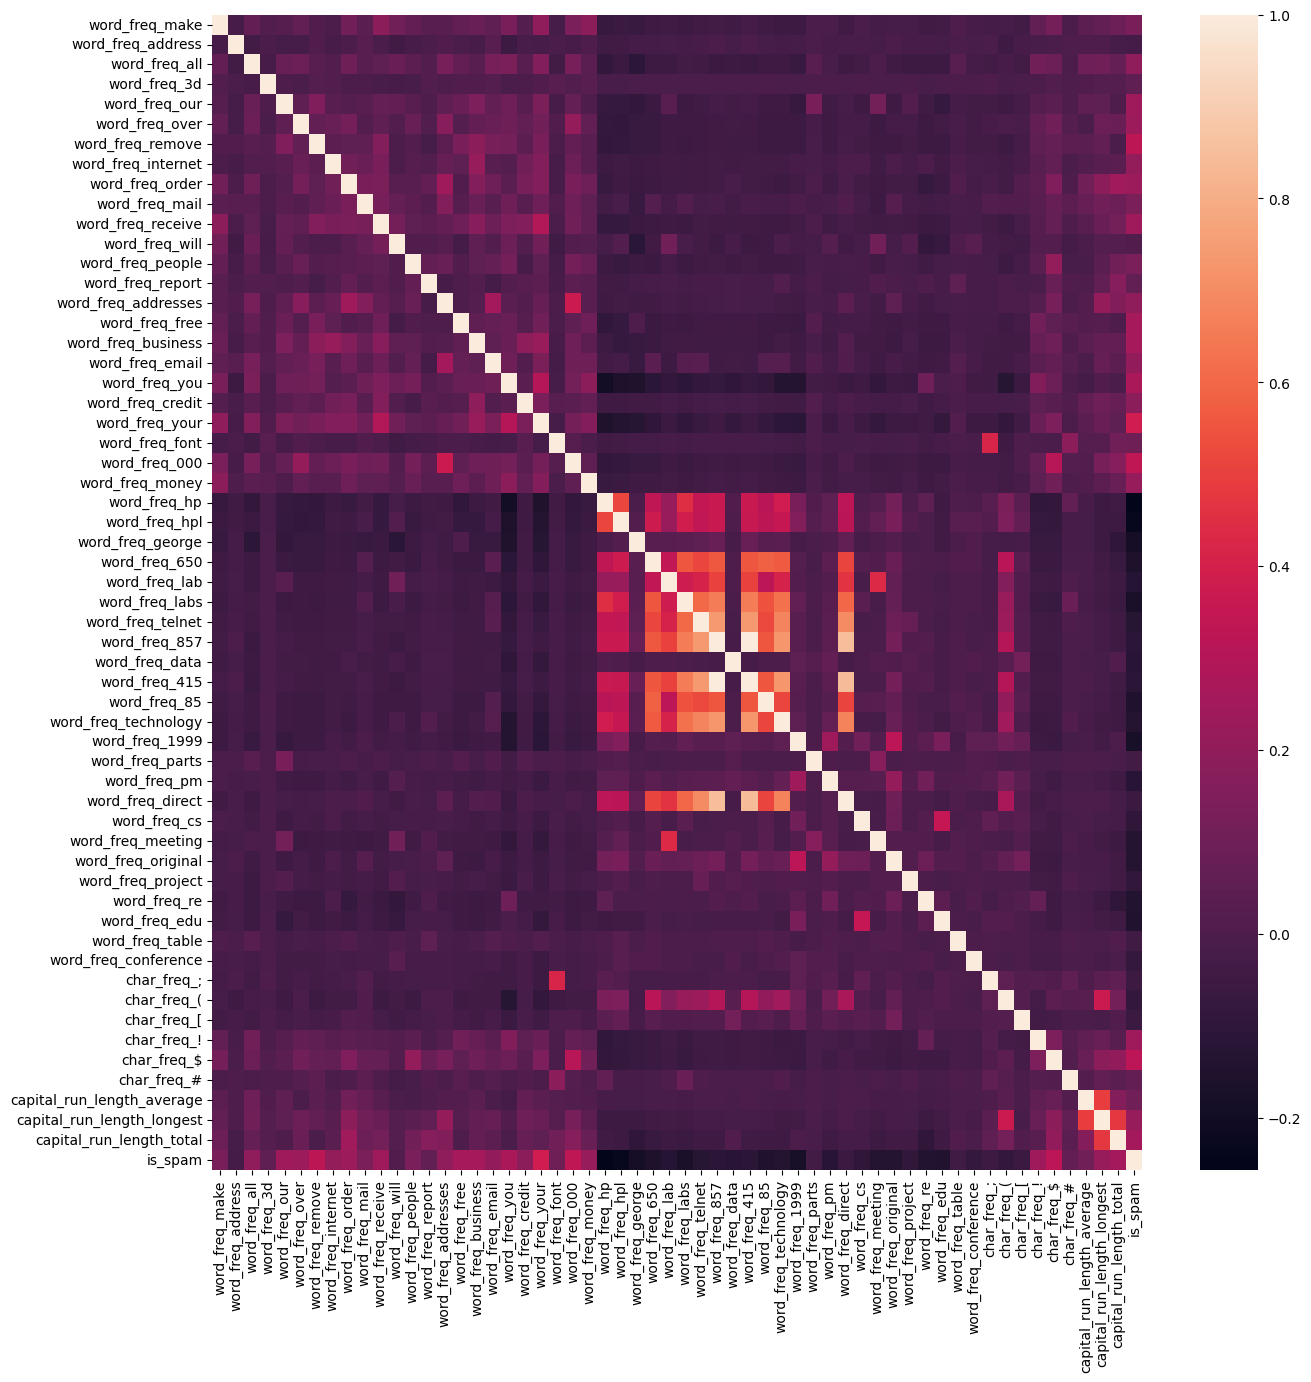

In [14]:
## correlation heatmap
import seaborn as sns
plt.figure(figsize=(15,15))
sns.heatmap(cormat);


In [15]:
## Getting the top 10 correlations
cormat_unstacked = cormat.abs().unstack().sort_values(ascending=False)
cormat_unstacked = cormat_unstacked[cormat_unstacked < 1]
top_10_correlations = cormat_unstacked.drop_duplicates().head(10)
print(top_10_correlations)


word_freq_415         word_freq_857           0.996066
word_freq_857         word_freq_direct        0.848021
word_freq_direct      word_freq_415           0.845359
word_freq_857         word_freq_telnet        0.737555
word_freq_telnet      word_freq_415           0.735187
word_freq_857         word_freq_technology    0.729750
word_freq_technology  word_freq_415           0.727119
word_freq_direct      word_freq_telnet        0.699918
word_freq_telnet      word_freq_technology    0.677790
word_freq_technology  word_freq_direct        0.674249
dtype: float64


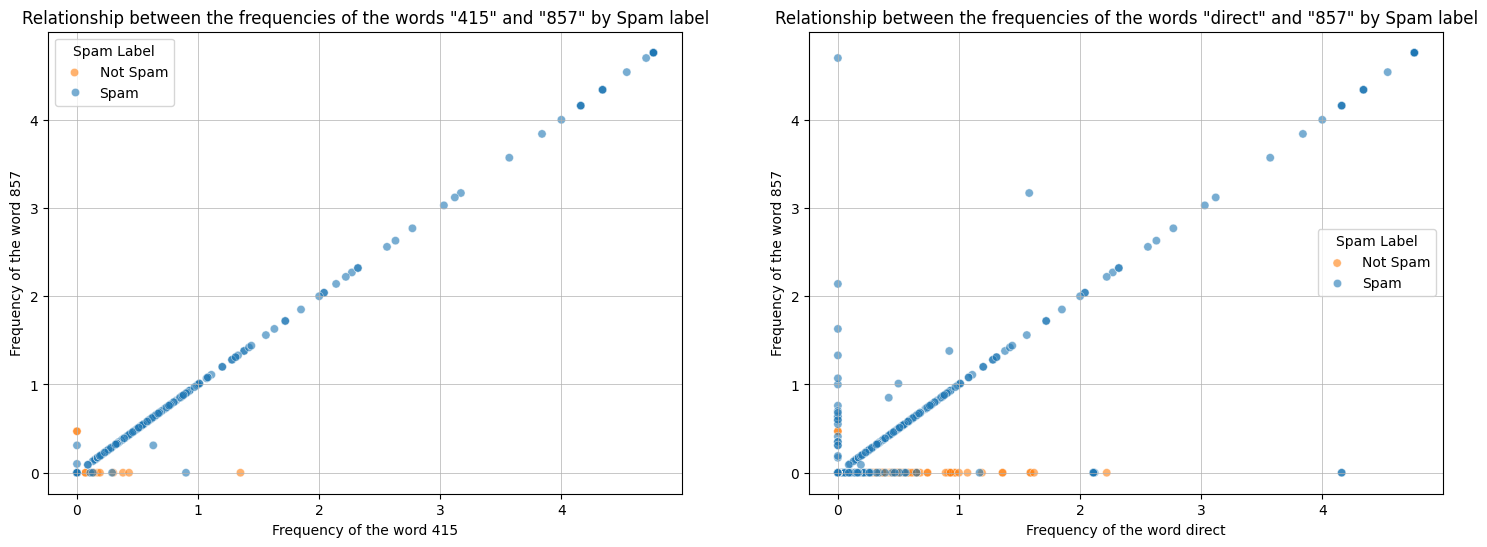

In [16]:
## Subplots of 2 of the most correlated features by spam label

fig, axes = plt.subplots(1, 2, figsize=(18, 6))  

sns.scatterplot(
    x=df['word_freq_415'],  
    y=df['word_freq_857'],
    hue=df['is_spam'],
    alpha=0.6, 
    ax=axes[0]
)

axes[0].grid(True, linestyle='-', linewidth=0.5)
axes[0].set_xlabel("Frequency of the word 415")
axes[0].set_ylabel("Frequency of the word 857")
axes[0].set_title('Relationship between the frequencies of the words "415" and "857" by Spam label')
axes[0].legend(title='Spam Label', labels=['Not Spam', 'Spam'])


sns.scatterplot(
    x=df['word_freq_direct'],  
    y=df['word_freq_857'],
    hue=df['is_spam'],
    alpha=0.6,
    ax=axes[1]

)

axes[1].grid(True, linestyle='-', linewidth=0.5)
axes[1].set_xlabel("Frequency of the word direct")
axes[1].set_ylabel("Frequency of the word 857")
axes[1].set_title('Relationship between the frequencies of the words "direct" and "857" by Spam label')
axes[1].legend(title='Spam Label', labels=['Not Spam', 'Spam'])



plt.show()


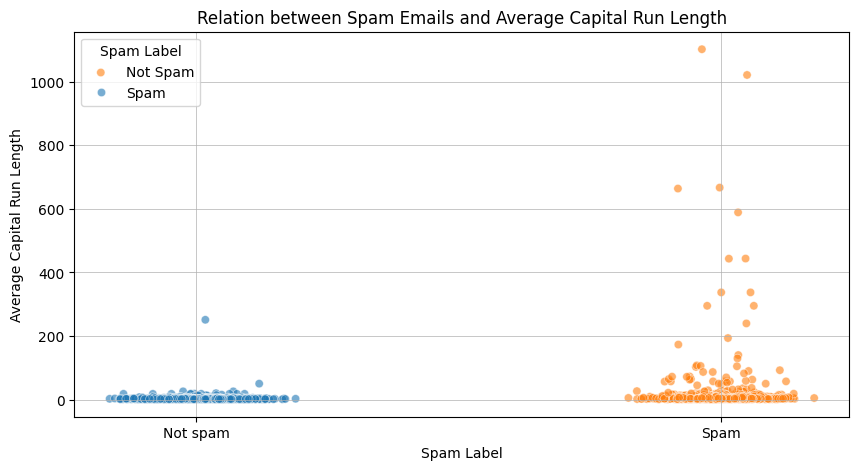

In [17]:
plt.figure(figsize=(10, 5))
sns.scatterplot(
    # I used jitter as is_spam is boolean so all values will have the same value, the plot would look like a straight line,
    # so jittering would spread the points to have a better representation in the plot
    x=np.random.normal(df['is_spam'], 0.05), 
    y=df['capital_run_length_average'],
    hue=df['is_spam'],
    alpha=0.6
)

plt.grid(True, linestyle='-', linewidth=0.5)
plt.xlabel("Spam Label")
# I only need 0 and 1 on the x axis (spam or not spam), so I excluded the other values
plt.xticks([0,1],['Not spam','Spam'])
plt.ylabel("Average Capital Run Length")
plt.title("Relation between Spam Emails and Average Capital Run Length")
plt.legend(title='Spam Label', labels=['Not Spam', 'Spam'])
plt.show()


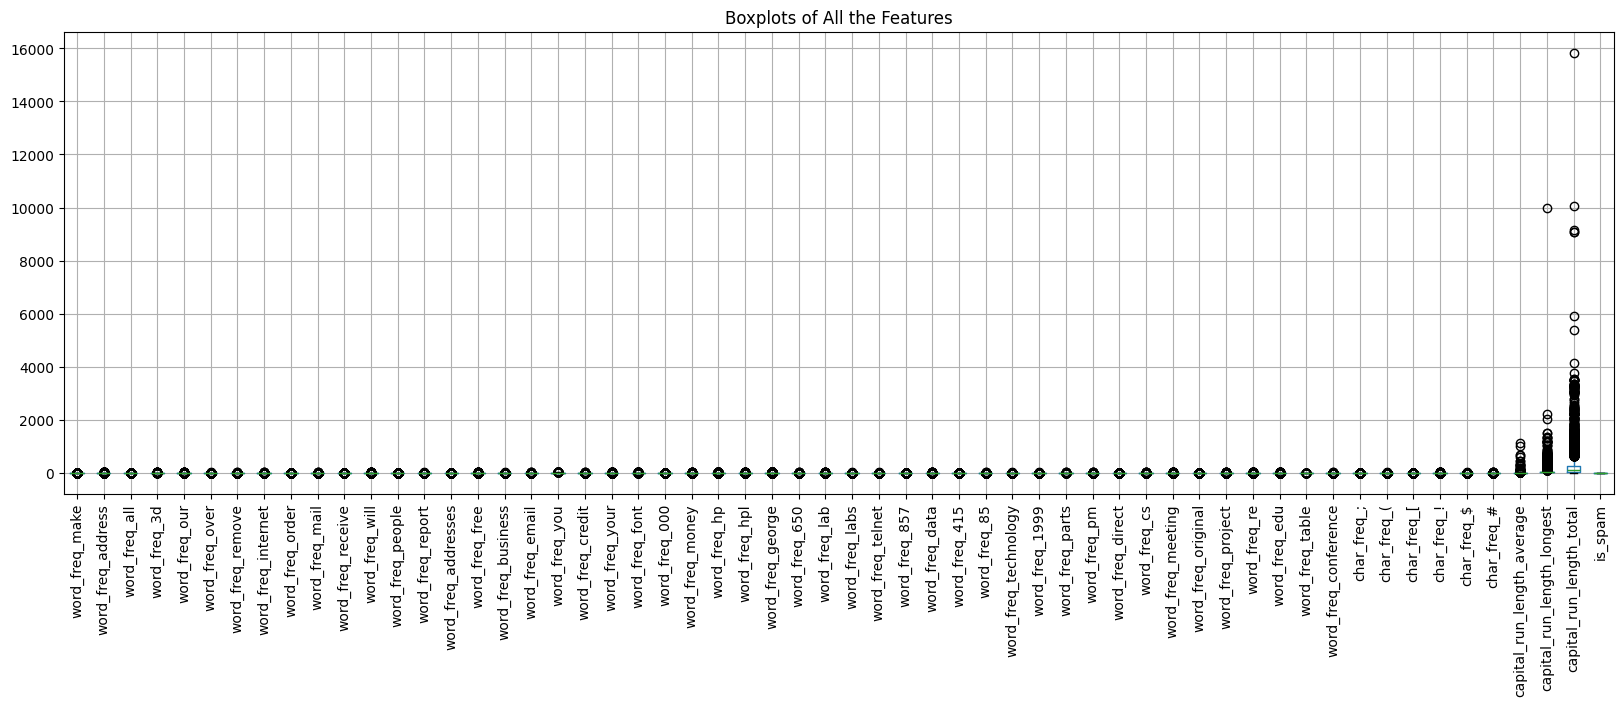

In [18]:
## Boxplot of all features
df.boxplot(figsize=(20, 6), rot=90)
plt.title('Boxplots of All the Features')
plt.show()

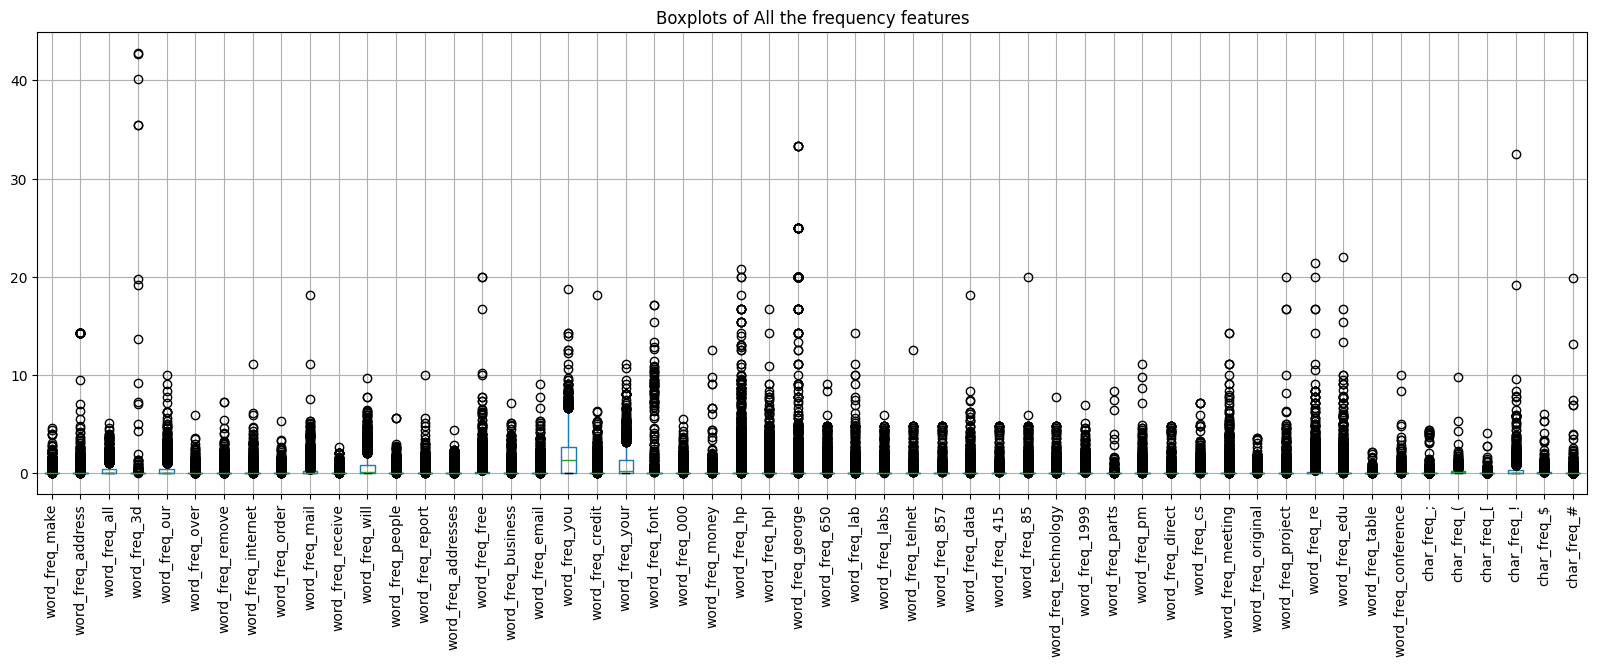

In [19]:
## I excluded the capital rung length related features
freq_df = df.iloc[:,0:54]
## Boxploat for the word frequencies features (float columns)
freq_df.boxplot(figsize=(20, 6), rot=90)
plt.title('Boxplots of All the frequency features')
plt.show()